In [1]:
import pandas as pd
import numpy as np
#실제 그래프를 그릴 수 있는 서브 함수
import matplotlib.pyplot as plt
import seaborn as sns

#경고표시 생략(일시적으로 생략하는게 좋음) 
import warnings
warnings.filterwarnings(action='ignore')

#한글폰트 지정 
import matplotlib.font_manager as fm
font_name= fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font",family=font_name)

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus']=False

import urllib.request as req
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
import urllib.parse
from bs4 import BeautifulSoup
import requests

## 1. 시카고 샌드위치 맛집 분석
- http://www.chicagomag.com/Chicago-Magazine/November-2012/Best-Sandwiches-Chicago


### (1) 데이터 준비 

In [12]:
# 기존 방법이 안먹힐때 
url ='https://www.chicagomag.com/Chicago-Magazine/November-2012/Best-Sandwiches-Chicago'
headers= {'User-Agent':'Mozilla/5.0'}
page= requests.get(url,headers=headers)
page
soup = BeautifulSoup(page.text, 'html.parser')
soup

<!DOCTYPE html>

<html lang="en-US">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<link href="https://gmpg.org/xfn/11" rel="profile"/>
<title>The 50 Best Sandwiches in Chicago – Chicago Magazine</title>
<style type="text/css">			.heateorSssInstagramBackground{background:radial-gradient(circle at 30% 107%,#fdf497 0,#fdf497 5%,#fd5949 45%,#d6249f 60%,#285aeb 90%)}
						div.heateor_sss_horizontal_sharing i.heateorSssInstagramBackground{background:#000!important;}div.heateor_sss_standard_follow_icons_container i.heateorSssInstagramBackground{background:#000;}
										.heateor_sss_horizontal_sharing .heateorSssSharing,.heateor_sss_standard_follow_icons_container .heateorSssSharing{
							background-color: #000;
							color: #fff;
						border-width: 0px;
			border-style: solid;
			border-color: transparent;
		}
				.heateor_sss_horizontal_sharing .heateorSssTCBackground{
			color:#666;
		}
				.heateor_sss_horizontal_sharing .heateorSssSharing:ho

In [14]:
len(soup.find_all('div','sammy'))

50

In [16]:
soup.find_all('div','sammy')[0]

<div class="sammy" style="position: relative;">
<div class="sammyRank">1</div>
<div class="sammyListing"><a href="/Chicago-Magazine/November-2012/Best-Sandwiches-in-Chicago-Old-Oak-Tap-BLT/"><b>BLT</b><br/>
Old Oak Tap<br/>
<em>Read more</em> </a></div>
</div>

### (2) Parsing

In [18]:
##### 50개 데이터 중에서 첫번째 데이터 가져오기
one = soup.find_all('div','sammy')[0]
print(type(one))
print(one)

<class 'bs4.element.Tag'>
<div class="sammy" style="position: relative;">
<div class="sammyRank">1</div>
<div class="sammyListing"><a href="/Chicago-Magazine/November-2012/Best-Sandwiches-in-Chicago-Old-Oak-Tap-BLT/"><b>BLT</b><br/>
Old Oak Tap<br/>
<em>Read more</em> </a></div>
</div>


In [24]:
##### 첫번째 데이터중에서 랭킹 가져오기 
one.find(class_='sammyRank').get_text()

'1'

In [23]:
##### 메뉴 이름과 가게 이름 가져오기
one_list = one.find(class_='sammyListing').get_text().split('\n')
print(one_list[0],one_list[1])

BLT Old Oak Tap


In [27]:
##### a 태그에서 href 값 가져오기 
one.a['href']

base = 'https://www.chicagomag.com'
print(base+url)

print(urllib.parse.urljoin(base,url)) # 이미 완전한 주소가 있으면 중복해서 들어가지 않음


https://www.chicagomag.comhttps://www.chicagomag.com/Chicago-Magazine/November-2012/Best-Sandwiches-Chicago
https://www.chicagomag.com/Chicago-Magazine/November-2012/Best-Sandwiches-Chicago


### (3) 데이터 수집 

+ rank
+ main_menu
+ cafe_name
+ readmore

In [39]:
rank = []
main_menu = []
cafe_name = []
readmore = []
url_base = 'https://www.chicagomag.com'
cafes= soup.find_all('div','sammy')
for item in cafes:
    rank.append(item.find(class_='sammyRank').get_text())
    
    temp= item.find(class_='sammyListing').get_text().split('\n')
    main_menu.append(temp[0])
    cafe_name.append(temp[1])
    
    readmore.append(urllib.parse.urljoin(url_base,item.find('a')['href']))

In [40]:
len(rank),len(main_menu),len(cafe_name),len(readmore)

(50, 50, 50, 50)

In [41]:
data = {'Rank':rank,'Cafe':cafe_name,'Menu':main_menu,'ReadMore':readmore}
df=pd.DataFrame(data)
df.head()

,Rank,Cafe,Menu,ReadMore
0,1,Old Oak Tap,BLT,https://www.chicagomag.com/Chicago-Magazine/No...
1,2,Au Cheval,Fried Bologna,https://www.chicagomag.com/Chicago-Magazine/No...
2,3,Xoco,Woodland Mushroom,https://www.chicagomag.com/Chicago-Magazine/No...
3,4,Al’s Deli,Roast Beef,https://www.chicagomag.com/Chicago-Magazine/No...
4,5,Publican Quality Meats,PB&L,https://www.chicagomag.com/Chicago-Magazine/No...


In [49]:
##### 상세 페이지에서 가격하고 주소가져오기 # 연습 
# read more에 이미 상세페이지 주소가 있어
# 일단 하나만 해보자 
url = df['ReadMore'][0]
headers= {'User-Agent':'Mozilla/5.0'}
page= requests.get(url,headers=headers)
soup = BeautifulSoup(page.text, 'html.parser')

detail = soup.find('p',class_='addy').get_text()
print(detail)

detail_split = detail.split() # 공백이 디폴트
print(detail_split)

#가격
print(detail_split[0])
print(detail_split[0][:-1]) # .을 빼고 가져오겠다면 

#주소
print(detail_split[1 :-2])


$10. 2109 W. Chicago Ave., 773-772-0406, theoldoaktap.com
['$10.', '2109', 'W.', 'Chicago', 'Ave.,', '773-772-0406,', 'theoldoaktap.com']
$10.
$10
['2109', 'W.', 'Chicago', 'Ave.,']


In [56]:
##### 50개 점포의 가격과 주소 수집 
import time
from tqdm import tqdm_notebook
price = []
address= []

for n in tqdm_notebook(df.index):
    page= requests.get(df['ReadMore'][n],headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    #time.sleep(1)
    detail = soup.find('p',class_='addy').get_text()
    price.append(detail.split()[0][:-1])
    address.append(' '.join(detail.split()[1 : -2]))
    

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
print(len(price),len(address))
print(price[:5])
print(address[:5])

50 50
['$10', '$9', '$9.50', '$9.40', '$10']
['2109 W. Chicago Ave.,', '800 W. Randolph St.,', '445 N. Clark St.,', '914 Noyes St., Evanston,', '825 W. Fulton Mkt.,']


['2109 W. Chicago Ave.,',
 '800 W. Randolph St.,',
 '445 N. Clark St.,',
 '914 Noyes St., Evanston,',
 '825 W. Fulton Mkt.,',
 '100 E. Walton',
 '1639 S. Wabash Ave.,',
 '2211 W. North Ave.,',
 '3619 W. North Ave.,',
 '3267 S. Halsted St.,',
 '2537 N. Kedzie Blvd.,',
 'Multiple',
 '3124 N. Broadway,',
 '3455 N. Southport Ave.,',
 '2657 N. Kedzie Ave.,',
 '1120 W. Grand Ave.,',
 '1141 S. Jefferson St.,',
 '333 E. Benton Pl.,',
 '1411 N. Wells St.,',
 '1747 N. Damen Ave.,',
 '3209 W. Irving Park',
 'Multiple',
 '5347 N. Clark St.,',
 '2954 W. Irving Park Rd.,',
 'Multiple',
 '191 Skokie Valley Rd., Highland Park,',
 'Multiple',
 '1818 W. Wilson Ave.,',
 '2517 W. Division St.,',
 '218 W. Kinzie',
 'Multiple',
 '1547 N. Wells St.,',
 '415 N. Milwaukee Ave.,',
 '1840 N. Damen Ave.,',
 '1220 W. Webster Ave.,',
 '5357 N. Ashland Ave.,',
 '1834 W. Montrose Ave.,',
 '615 N. State St.,',
 'Multiple',
 '241 N. York Rd., Elmhurst,',
 '1323 E. 57th St.,',
 '655 Forest Ave., Lake Forest,',
 'Hotel L

In [60]:
df['Price']=price
df['Address']=address
df.head()

,Rank,Cafe,Menu,ReadMore,Price,Address
0,1,Old Oak Tap,BLT,https://www.chicagomag.com/Chicago-Magazine/No...,$10,"2109 W. Chicago Ave.,"
1,2,Au Cheval,Fried Bologna,https://www.chicagomag.com/Chicago-Magazine/No...,$9,"800 W. Randolph St.,"
2,3,Xoco,Woodland Mushroom,https://www.chicagomag.com/Chicago-Magazine/No...,$9.50,"445 N. Clark St.,"
3,4,Al’s Deli,Roast Beef,https://www.chicagomag.com/Chicago-Magazine/No...,$9.40,"914 Noyes St., Evanston,"
4,5,Publican Quality Meats,PB&L,https://www.chicagomag.com/Chicago-Magazine/No...,$10,"825 W. Fulton Mkt.,"


#### -check point

In [61]:
df.to_csv('data/sandwiches_final.csv',encoding='utf-8')

In [2]:
df= pd.read_csv('data/sandwiches_final.csv', index_col=0)
df.head()

,Rank,Cafe,Menu,ReadMore,Price,Address
0,1,Old Oak Tap,BLT,https://www.chicagomag.com/Chicago-Magazine/No...,$10,"2109 W. Chicago Ave.,"
1,2,Au Cheval,Fried Bologna,https://www.chicagomag.com/Chicago-Magazine/No...,$9,"800 W. Randolph St.,"
2,3,Xoco,Woodland Mushroom,https://www.chicagomag.com/Chicago-Magazine/No...,$9.50,"445 N. Clark St.,"
3,4,Al’s Deli,Roast Beef,https://www.chicagomag.com/Chicago-Magazine/No...,$9.40,"914 Noyes St., Evanston,"
4,5,Publican Quality Meats,PB&L,https://www.chicagomag.com/Chicago-Magazine/No...,$10,"825 W. Fulton Mkt.,"


In [3]:
df = pd.read_csv('data/sandwiches_map.csv',index_col=0)
df.head()

,Menu,Cafe,ReadMore,Price,Address,Latitude,Longitude
Rank,,,,,,,
1,BLT,Old Oak Tap,https://www.chicagomag.com/Chicago-Magazine/No...,$10,2109 W. Chicago Ave.,41.895605,-87.679961
2,Fried Bologna,Au Cheval,https://www.chicagomag.com/Chicago-Magazine/No...,$9,800 W. Randolph St.,41.884658,-87.647667
3,Woodland Mushroom,Xoco,https://www.chicagomag.com/Chicago-Magazine/No...,$9.50,445 N. Clark St.,41.890523,-87.630783
4,Roast Beef,Al’s Deli,https://www.chicagomag.com/Chicago-Magazine/No...,$9.40,914 Noyes St.,42.058322,-87.683748
5,PB&L,Publican Quality Meats,https://www.chicagomag.com/Chicago-Magazine/No...,$10,825 W. Fulton Mkt.,41.886604,-87.648536


In [14]:
import folium

map= folium.Map(location=[df['Latitude'].mean(),df['Longitude'].mean()],
               zoom_start=11)
folium.Marker([df['Latitude'].mean(),df['Longitude'].mean()],popup='center').add_to(map)
map

### 2. 네이버 영화평점 기준으로 영화 평점 변화 분석 

+ https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&date=20170806

In [2]:
## 데이터 준비
url= 'https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&date=20170806'
page = urlopen(url)
soup= BeautifulSoup(page,'html.parser')
soup
# page.text는 객체가 다를경우 - request로 받아 text를 가져왔기 때문
# urlopen으로 받기 때문에 그냥 page만 사용해도 댐.


<!DOCTYPE html>

<html lang="ko">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="http://imgmovie.naver.com/today/naverme/naverme_profile.jpg" property="me2:image">
<meta content="네이버영화 " property="me2:post_tag">
<meta content="네이버영화" property="me2:category1"/>
<meta content="" property="me2:category2"/>
<meta content="랭킹 : 네이버 영화" property="og:title"/>
<meta content="영화, 영화인, 예매, 박스오피스 랭킹 정보 제공" property="og:description"/>
<meta content="article" property="og:type"/>
<meta content="https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&amp;date=20170806" property="og:url"/>
<meta content="http://static.naver.net/m/movie/icons/OG_270_270.png" property="og:image"/><!-- http://static.naver.net/m/movie/im/navermovie.jpg -->
<meta content="http://imgmovie.naver.com/today/naverme/naverme_profile.jpg" property="og:article:thumbnailUrl"/>
<meta content="네이버 영화" property="og:article:author"/

In [3]:
# 영화 제목만 뽑아오기
print(soup.find_all('div','tit5'))
print(soup.find_all('div','tit5')[0])

[<div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=62586" title="다크 나이트">다크 나이트</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=164290" title="킹 오브 프리즘 프라이드 더 히어로">킹 오브 프리즘 프라이드 더 히어로</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=152160" title="킹 오브 프리즘">킹 오브 프리즘</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=154437" title="내 사랑">내 사랑</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=10448" title="오즈의 마법사">오즈의 마법사</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=160135" title="서서평, 천천히 평온하게">서서평, 천천히 평온하게</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=10217" title="로보캅">로보캅</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=76309" title="플립">플립</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=31827" title="헤드윅">헤드윅</a>
</div>, <div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=153621" title="댄서">댄서</a

In [4]:
print(len(soup.find_all('div','tit5')))

47


In [5]:
# 영화 제목만 딱 가져오겠다 
print(soup.find_all('div','tit5')[0])
print(soup.find_all('div','tit5')[0].get_text())

<div class="tit5">
<a href="/movie/bi/mi/basic.naver?code=62586" title="다크 나이트">다크 나이트</a>
</div>

다크 나이트



In [6]:
# 평점만 가져오기
#print(soup.find_all('td',class_='point'))
print(soup.find_all('td',class_='point')[0])
print(soup.find_all('td',class_='point')[0].get_text())

<td class="point">9.32</td>
9.32


In [7]:
print(len(soup.find_all('td',class_='point')))

47


In [8]:
# 하나의 페이지에서 영화제목, 평점을 모아두려고 한다면?
# 47개의 영화 제목과 평점을 리스트 저장 
movie_name=[soup.find_all('div','tit5')[n].get_text() for n in range(47)]
movie_potint=[soup.find_all('td','point')[n].get_text() for n in range(47)]

print(movie_name)
print(movie_potint)

['\n다크 나이트\n', '\n킹 오브 프리즘 프라이드 더 히어로\n', '\n킹 오브 프리즘\n', '\n내 사랑\n', '\n오즈의 마법사\n', '\n서서평, 천천히 평온하게\n', '\n로보캅\n', '\n플립\n', '\n헤드윅\n', '\n댄서\n', '\n이터널 선샤인\n', '\n명탐정 코난:진홍의 연가\n', '\n샤인\n', '\n택시운전사\n', '\n올드보이\n', '\n어네스트와 셀레스틴\n', '\n기쿠지로의 여름\n', '\n파도가 지나간 자리\n', '\n노무현입니다\n', '\n파이트 클럽\n', '\n스타쉽 트루퍼스\n', '\n청원\n', '\n토탈 리콜\n', '\n극장판 짱구는 못말려 : 습격!! 외계인 덩덩이\n', '\n너의 이름은.\n', '\n연애담\n', '\n슈퍼배드 3\n', '\n꿈의 제인\n', '\n심야식당2\n', '\n라라랜드\n', '\n카3: 새로운 도전\n', '\n오두막\n', '\n스파이더맨: 홈커밍\n', '\n옥자\n', '\n500일의 썸머\n', '\n복수는 나의 것\n', '\n덩케르크\n', '\n예수는 역사다\n', '\n매치 포인트\n', '\n7번째 내가 죽던 날\n', '\n47 미터\n', '\n친절한 금자씨\n', '\n송 투 송\n', '\n그 후\n', '\n박쥐\n', '\n싸이보그지만 괜찮아\n', '\n군함도\n']
['9.32', '9.27', '9.25', '9.24', '9.23', '9.23', '9.21', '9.20', '9.18', '9.14', '9.10', '9.10', '9.09', '9.08', '9.05', '9.05', '9.02', '9.00', '8.93', '8.91', '8.90', '8.87', '8.86', '8.83', '8.76', '8.75', '8.73', '8.70', '8.62', '8.59', '8.58', '8.48', '8.48', '8.47', '8.39', '8.34', '8.32', '8.12', '7.97

### (1) 데이터 수집

+ 2017년 5월 1일 부터 100일 간의 데이터 수집
    - 페이지를 옮겨가면서 해야하는데 옮기면 주소가 달라짐.-> 파라미터로 
    - date=20170806

In [9]:
daterange = pd.date_range('2017-05',periods=100,freq='D')
daterange

DatetimeIndex(['2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05',
               '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09',
               '2017-06-10', '2017-06-11', '2017-06-12', '2017-06-13',
               '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-17',
               '2017-06-18', '2017-06-19', '2017-06-20', '2017-06-21',
               '2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
      

In [10]:
from tqdm import tqdm_notebook

movie_date=[]
movie_name=[]
movie_point=[]

for today in tqdm_notebook(daterange):
    url= 'https://movie.naver.com/movie/sdb/rank/rmovie.naver?sel=cur&date={}'
    #인덱스는 2017-08-08 형태 --> 네이버는 20170808 가공처리 해야함
    page =urlopen(url.format(today.strftime('%Y%m%d')))
    soup = BeautifulSoup(page,'html.parser')
    
    # 날마다 영화개수가 다를 수 있음 그래서 세줘야 함
    cnt = len(soup.find_all('td','point'))
    
    movie_date.extend([today for n in range(cnt)])
    movie_name.extend(soup.find_all('div','tit5')[n].get_text().strip('\n') for n in range(cnt))
    movie_point.extend([soup.find_all('td','point')[n].get_text().strip('\n') for n in range(cnt)])
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
len( movie_date), len(movie_point),len(movie_name)

(4723, 4723, 4723)

In [12]:
### 데이터 프레임으로 옮기기 
data = {'Date':movie_date,'Name':movie_name,'Point':movie_point}
df=pd.DataFrame(data)
df.head()

,Date,Name,Point
0,2017-05-01,히든 피겨스,9.38
1,2017-05-01,사운드 오브 뮤직,9.36
2,2017-05-01,시네마 천국,9.29
3,2017-05-01,미스 슬로운,9.26
4,2017-05-01,잉여들의 히치하이킹,9.25


In [13]:
# 데이터 프레임 한번에 만들기 
df=pd.DataFrame({'Date':movie_date,'Name':movie_name,'Point':movie_point})


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723 entries, 0 to 4722
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4723 non-null   datetime64[ns]
 1   Name    4723 non-null   object        
 2   Point   4723 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 110.8+ KB


In [15]:
df['Point']=df['Point'].astype(float)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723 entries, 0 to 4722
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4723 non-null   datetime64[ns]
 1   Name    4723 non-null   object        
 2   Point   4723 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 110.8+ KB


,Date,Name,Point
0,2017-05-01,히든 피겨스,9.38
1,2017-05-01,사운드 오브 뮤직,9.36
2,2017-05-01,시네마 천국,9.29
3,2017-05-01,미스 슬로운,9.26
4,2017-05-01,잉여들의 히치하이킹,9.25


In [ ]:
# 이후 분석은 앞에서 데이터 프레임 분석하는것과 동일하게 
# 전처리 하고, 그래프 그리고 하면서 하면 됨. 
# e.g. 어떤 영화가 점점 평점이 좋아 지는지

In [ ]:
# 로그인을 해야하는 페이지 같은 경우는  데이터를 긁어 오기 힘들어유

In [28]:
#  연습문제 
##### 영화별로 점수의 합계를 조회(평점의 합계가 높은 순 또는 낮은 순으로 10개씩)
m_point=pd.pivot_table(df,index=['Name'],aggfunc=np.sum)
m_point.sort_values(by='Point',ascending=False).head(10)

df.groupby('Name')[['Point']].sum().sort_values('Point',ascending=False).head(10)

,Point
Name,
댄서,914.60
"서서평, 천천히 평온하게",889.64
오두막,861.65
라라랜드,858.89
너의 이름은.,738.42
노무현입니다,682.24
보스 베이비,644.21
겟 아웃,630.62
기쿠지로의 여름,613.43


           Date  Name  Point
833  2017-05-17  겟 아웃   8.36
889  2017-05-18  겟 아웃   8.18
933  2017-05-19  겟 아웃   8.20
980  2017-05-20  겟 아웃   8.18
1022 2017-05-21  겟 아웃   8.18
1061 2017-05-22  겟 아웃   8.11
1102 2017-05-23  겟 아웃   8.15
1146 2017-05-24  겟 아웃   8.15
1192 2017-05-25  겟 아웃   8.15
1236 2017-05-26  겟 아웃   8.16
           Date  Name  Point
3919 2017-07-23  겟 아웃   8.21
3968 2017-07-24  겟 아웃   8.21
4021 2017-07-25  겟 아웃   8.21
4069 2017-07-26  겟 아웃   8.21
4119 2017-07-27  겟 아웃   8.21
4169 2017-07-28  겟 아웃   8.21
4218 2017-07-29  겟 아웃   8.21
4267 2017-07-30  겟 아웃   8.21
4319 2017-07-31  겟 아웃   8.21
4372 2017-08-01  겟 아웃   8.21


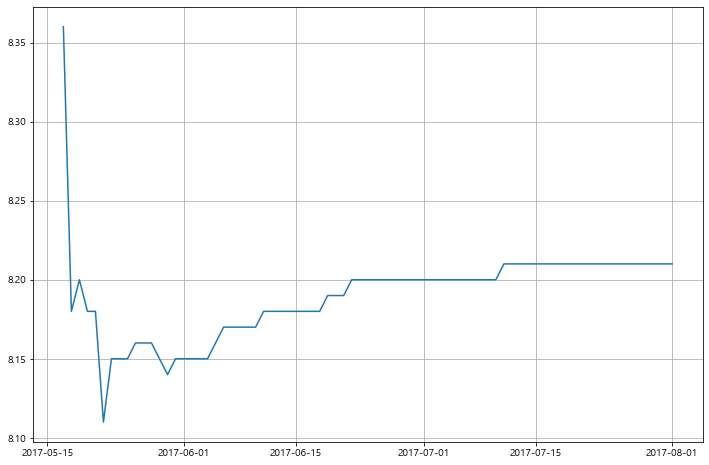

In [39]:
##### 특정 영화만 골라서 조회(예를들어 겟아웃을 10일치까지만 조회)
getout = df.query("Name==['겟 아웃']")
print(getout.head(10))
print(getout.tail(10))

# 인덱싱으로 확인하기 
getout=df[df['Name']=='겟 아웃']
getout.head(10)
getout.tail(10)



##### 위에 조회한 영화에 대해 날짜별 평점으로 시각화(100일 전체)(선그래프)
plt.figure(figsize=(12,8))
plt.plot('Date','Point',data=getout)
plt.grid()


In [48]:
##### 영화별 날짜 변화에 따른 평점 변화를 확인(데이터 프레임 구성)
movie = df.pivot_table(index =['Date'],columns=['Name'],values=['Point'])
movie.head()

#이중컬럼으로 되어 있어서 그거 지워주기 
movie.columns = movie.columns.droplevel()
movie.head()


Name,10분,47 미터,500일의 썸머,7년-그들이 없는 언론,7번째 내가 죽던 날,7인의 사무라이,8 마일,가디언즈 오브 갤럭시,가디언즈 오브 갤럭시 VOL. 2,겟 아웃,...,하울의 움직이는 성,하이큐!! 끝과 시작,한공주,해리가 샐리를 만났을 때,핵소 고지,행복 목욕탕,헤드윅,환상의 빛,흑집사 : 북 오브 더 아틀란틱,히든 피겨스
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-01,8.89,NaN,NaN,NaN,NaN,NaN,NaN,8.56,NaN,NaN,...,NaN,NaN,8.78,8.89,NaN,8.70,NaN,NaN,9.20,9.38
2017-05-02,8.89,NaN,NaN,NaN,NaN,NaN,NaN,8.56,NaN,NaN,...,NaN,NaN,8.78,8.89,NaN,8.68,NaN,NaN,9.21,9.37
2017-05-03,8.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.22,NaN,...,NaN,NaN,8.78,8.89,NaN,8.70,NaN,NaN,9.22,9.38
2017-05-04,8.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.15,NaN,...,NaN,NaN,8.78,NaN,NaN,8.67,NaN,NaN,9.23,9.38
2017-05-05,8.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.08,NaN,...,NaN,NaN,8.78,NaN,NaN,8.69,NaN,NaN,9.24,9.37


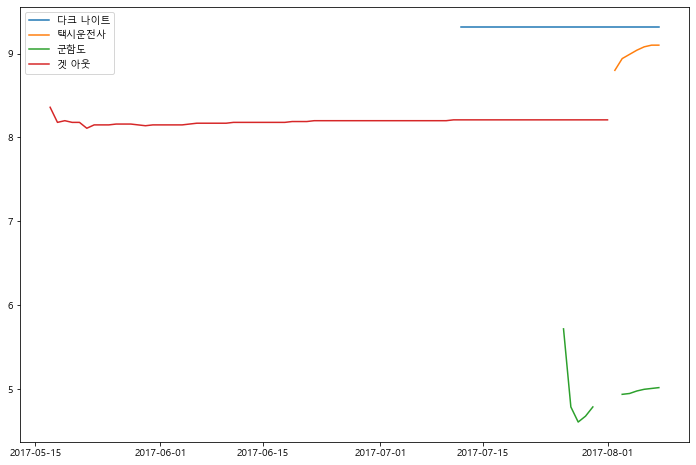

In [52]:
##### 위의 결과 중 몇개의 영화를 뽑아서 평점 변화에 대한 시각화 구현(하나의 선그래프로 구현)
target = ['다크 나이트', '택시운전사','군함도','겟 아웃']
plt.figure(figsize=(12,8))
plt.plot(movie[target])
plt.legend(target,loc='best') # 범례 최적합한데에 그려라 